In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
from scipy.stats import norm

general Parameters

In [38]:
T = 1
k = 3
d = 2**k
delta_t = T/d

S_0 = 100
mu = 0.045
sigma = 0.3

mc_runs = 1000


Create Brownian Bridges

In [42]:
def create_BB(mc_runs, d, delta_t):
    h = d                       #h : Differenz der Punkte in Indexpunkten
    X = np.empty((mc_runs,d+1))       #+1 damit die 0 am Anfang mit dabei ist
    X[:,0] = 0
    X[:,d] = np.sqrt(d * delta_t) * np.random.randn(mc_runs)
    for i in range(k):
        h = int(h/2)
        pos = h
        for j in range(2**i):
            X[:,pos] = (1/2) * X[:,pos - h] + (1/2) * X[:,pos + h] + np.sqrt((1/2) * h * delta_t) * np.random.randn(mc_runs)
            #print(pos)
            pos = pos + 2*h
    return X

Create Asset prices

In [47]:
def create_asset_prices(mc_runs, d, delta_t, S_0, mu, sigma):
    S = np.empty([mc_runs, d+1]) #+1 weil d mal simuliert wird und aber der Startpreis des Assets auch in dem Vektor steht
    
    S[:,0] = S_0

    BM = create_BB(mc_runs, d, delta_t)  #w_0 ist nciht dabei aber interessiert mich auch nicht

    for k in range(mc_runs):
        for i in range(d):
            S[k, i+1] = S[k, 0]*np.exp(sigma*BM[k, i+1] + (mu-(sigma**2)/2)*(i+1)*delta_t)  #hier BM[i+1] weil BM[0]=0 mit im Vektor isr
    return S
    

Calculate Payoff

In [48]:
def ratched_option(mc_runs, d, delta_t, S_0, mu, sigma): 
    S = create_asset_prices(mc_runs, d, delta_t, S_0, mu, sigma)

    indic = np.diff(S)>0

    payoff = (indic*S[:,1:S.size]).mean(axis=1)  #python spezifisch fehlt dann das erste Element

    #plt.plot(S.T)
    #plt.title("Simulation of "+str(mc_runs)+" sample paths of Asset Prices ")
    #plt.show()
    return payoff

# Monte Carlo Simulation

Exaktes Ergebnis

In [65]:
Exp = (S_0/d)*norm.cdf((mu-((sigma**2)/2))*math.sqrt(delta_t)/sigma+sigma*math.sqrt(delta_t))*np.sum(np.exp(mu*delta_t*(np.array(range(d))+1)))
display(Exp)

55.618171509982446

Monte Carlo Simulation mit Brownian Bridges

In [49]:
mc_expectation = ratched_option(mc_runs, d, delta_t, S_0, mu, sigma).mean()
mc_expectation

55.41394823221917

Fehlerberechnung RMSE in Option paper ist es aber irgendwie relativ (weil so nicht wirklich vergleichbar mit verschiedenen Längen der Option)

In [85]:
n = np.linspace(10,100000, 1000, dtype = int)
mc_expectation = np.empty(len(n))
mc_runs = int(n[len(n)-1])
payoff = ratched_option(mc_runs, d, delta_t, S_0, mu, sigma)

for i in range(len(n)):
    mc_expectation[i] = payoff[:n[i]].mean()


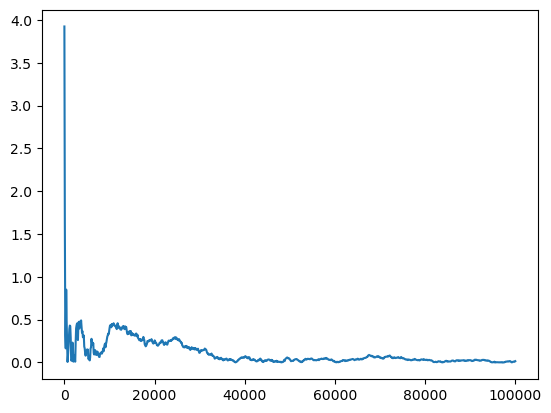

In [88]:
plt.plot(n, np.sqrt((mc_expectation - Exp)**2))
plt.show()